# Spatial gemeente stuff intro

In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import shapely.geometry as sg

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import contextily as cx

import requests
import json

import functions_spatial_intro as f

Spatial data, also known as geospatial data, is data associated with a geographic location, such as latitude and longitude coordinates.

Examples of spatial data include point data (e.g. GPS coordinates), line data (e.g. roads, rivers, etc.), polygon data (e.g. countries, states, etc.), and raster data (e.g. satellite imagery).

Spatial data is used in a variety of fields including geography, cartography, urban planning, land surveying, remote sensing, and GIS (geographic information systems).

Spatial data can be used to identify patterns, trends, and correlations that would otherwise be difficult to detect. It can also be used to make informed decisions and to better understand the world.

 Thank you ChatGPT!

## 0. Geo basics

### CRS

A Coordinate Reference System (CRS) is a coordinate-based system used to identify locations on the Earth’s surface. A CRS tells Python how coordinates relate to places on the Earth. 

We frequently use EPSG 4326 and EPSG 28992. A benefit of the first is that the coordinates are recognizable and can be used for example directly in Google Maps. A benefit of the latter is that calculated distances and areas are in meters. 

In [2]:
CRS = 'epsg:28992'

### Shapely

Shapely is a Python package for manipulation and analysis of planar geometric objects. We will be using Shapely geometries here (imported as sg).

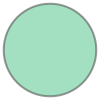

In [3]:
# Creating a polygon from scratch
polygon = sg.Point(0.0, 0.0).buffer(10.0)
polygon

### Geopandas and GeoDataFrame

Geopandas is a Python library that extends the popular Pandas library to work with geographic data. It enables the use of geospatial data in data analysis and makes it easier to query and manipulate spatial data. Geopandas provides spatial operations on geometric types, and can read and write a variety of geographic data formats. 

A geopandas GeoDataFrame is an extension of pandas DataFrame that contains a special column with geometry information. It is used to represent data associated with geographic objects such as points, lines, and polygons and enables analysis on it. 

In [4]:
# Creating a GeoDataFrame from scratch (https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html)
d = {'col1': ['name1', 'name2'], 
     'geometry': [sg.Point(1, 2), sg.Point(2, 1)]}

gdf = gpd.GeoDataFrame(d, crs=CRS)
gdf

,col1,geometry
0,name1,POINT (1.000 2.000)
1,name2,POINT (2.000 1.000)


<AxesSubplot:>

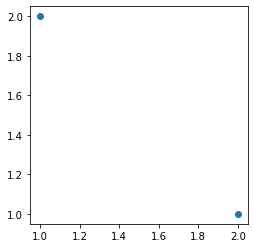

In [5]:
gdf.plot()

In [6]:
gdf.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

## 1. Administrative areas of Amsterdam

For administrative purposes, the city is divided in pieces, on different levels: 'stadsdelen', 'gebieden', 'wijken' and 'buurten'. These can be viewed here: https://maps.amsterdam.nl/gebiedsindeling/. Data can be retrieved from an API: https://api.data.amsterdam.nl/v1/docs/datasets/gebieden.html

In [7]:
# Select area granularity (buurten/wijken/ggwgebieden/stadsdelen)
area_choice = 'wijken'

In [8]:
# Get area data
area_url = "https://api.data.amsterdam.nl/v1/gebieden/" + area_choice + "/?_format=geojson" 
gdf_area_raw = gpd.read_file(area_url)

In [9]:
# Select columns of geodataframe
gdf_area = gdf_area_raw[['geometry', 'code', 'naam']]

In [10]:
gdf_area.head(2)

,geometry,code,naam
0,"POLYGON ((4.85741 52.34983, 4.85675 52.35126, ...",KB,Schinkelbuurt
1,"POLYGON ((4.95491 52.40109, 4.95396 52.40165, ...",NJ,Waterlandpleinbuurt


In [11]:
gdf_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# Adjust crs
gdf_area = gdf_area.to_crs(CRS)

<AxesSubplot:>

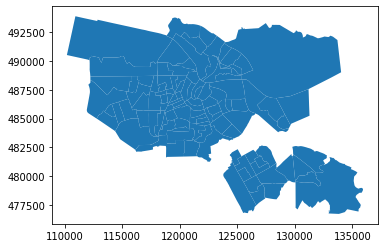

In [13]:
gdf_area.plot()

## 2. BGT

The Basisregistratie Grootschalige Topografie (BGT) is a national geo-information database managed by the Dutch government. It contains detailed digital topographic information about the Netherlands, including land use, buildings, roads, water features, and other features. It is used by a range of government and private sector organisations to support activities such as urban planning, infrastructure maintenance, and emergency services. To check out the different layers: https://www.amsterdam.nl/stelselpedia/bgt-index/producten-bgt/prodspec-bgt-dgn-imgeo

In [14]:
# Select layers
#bgt_layers = ['BGT_WDL_waterloop', 'BGT_WDL_watervlakte']   
bgt_layers = ['BGT_WGL_voetpad']

In [15]:
# Select location
bbox = None  # Get all data, entire Amsterdam
#bbox = ((122000, 485550), (122300, 485250))

In [16]:
# Get BGT data
gdf_bgt = f.get_bgt_data_for_bbox(bbox, bgt_layers) 

In [17]:
gdf_bgt.head(2)

,geometry,identificatie_lokaalid,naam
ogc_fid,,,
24687,"POLYGON ((111791.593 487855.226, 111864.777 48...",G0394.816d7b10c1a24781a88b1350e0631edb,voetpad
24688,"POLYGON ((111657.094 487706.409, 111706.050 48...",G0394.9b1f39acfc3b45b895719117ee63f717,voetpad


In [18]:
gdf_bgt.dtypes

geometry                  geometry
identificatie_lokaalid      object
naam                        object
dtype: object

<AxesSubplot:>

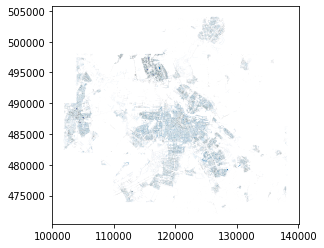

In [19]:
gdf_bgt.plot()

## 3. Spatial joins

There are two ways to combine datasets in geopandas – attribute joins and spatial joins.

In an attribute join, a GeoSeries or GeoDataFrame is combined with a regular pandas.Series or pandas.DataFrame based on a common variable. This is analogous to normal merging or joining in pandas.

In a Spatial Join, observations from two GeoSeries or GeoDataFrame are combined based on their spatial relationship to one another.

(https://geopandas.org/en/stable/docs/user_guide/mergingdata.html)

In [20]:
# Check if both geodataframes have the same crs
print(gdf_area.crs)
print(gdf_bgt.crs)

epsg:28992
epsg:28992


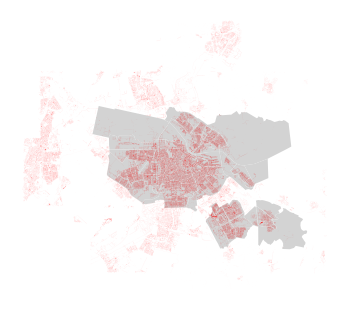

In [21]:
# Plot geodataframes together
fig, ax = plt.subplots(figsize=(6,6))

gdf_area.plot(ax=ax, color='lightgrey')
gdf_bgt.plot(ax=ax, color='red')

ax.axis('off')
plt.show()

In [22]:
# Get the area of each polygon 
gdf_bgt['area'] = gdf_bgt.geometry.area.round(2)

In [23]:
gdf_bgt.head(2)

,geometry,identificatie_lokaalid,naam,area
ogc_fid,,,,
24687,"POLYGON ((111791.593 487855.226, 111864.777 48...",G0394.816d7b10c1a24781a88b1350e0631edb,voetpad,384.71
24688,"POLYGON ((111657.094 487706.409, 111706.050 48...",G0394.9b1f39acfc3b45b895719117ee63f717,voetpad,281.87


In [24]:
gdf_area.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [25]:
# Do a left spatial join (note that the left geometry column remains)
gdf_area_bgt = gdf_area.sjoin(gdf_bgt[['geometry', 'area']], how='left', predicate='contains')

In [26]:
gdf_area_bgt

,geometry,code,naam,index_right,area
0,"POLYGON ((118902.282 484789.857, 118858.750 48...",KB,Schinkelbuurt,44789,3.67
0,"POLYGON ((118902.282 484789.857, 118858.750 48...",KB,Schinkelbuurt,44786,33.80
0,"POLYGON ((118902.282 484789.857, 118858.750 48...",KB,Schinkelbuurt,44787,3.91
0,"POLYGON ((118902.282 484789.857, 118858.750 48...",KB,Schinkelbuurt,44777,1387.20
0,"POLYGON ((118902.282 484789.857, 118858.750 48...",KB,Schinkelbuurt,44784,186.65
...,...,...,...,...,...
109,"POLYGON ((120338.659 487970.252, 120456.200 48...",EJ,Frederik Hendrikbuurt,110564,352.48
109,"POLYGON ((120338.659 487970.252, 120456.200 48...",EJ,Frederik Hendrikbuurt,109873,34.68
109,"POLYGON ((120338.659 487970.252, 120456.200 48...",EJ,Frederik Hendrikbuurt,110702,184.10
109,"POLYGON ((120338.659 487970.252, 120456.200 48...",EJ,Frederik Hendrikbuurt,109828,99.21


In [27]:
# Do a right spatial join (note that the right geometry column remains, and all rows of right dataframe)
gdf_bgt_area = gdf_area.sjoin(gdf_bgt[['geometry', 'area']], how='right', predicate='contains')

In [28]:
gdf_bgt_area

,index_left,code,naam,geometry,area
ogc_fid,,,,,
24687,NaN,NaN,NaN,"POLYGON ((111791.593 487855.226, 111864.777 48...",384.71
24688,NaN,NaN,NaN,"POLYGON ((111657.094 487706.409, 111706.050 48...",281.87
24722,NaN,NaN,NaN,"POLYGON ((111028.962 487775.108, 111070.206 48...",210.79
24676,NaN,NaN,NaN,"POLYGON ((111386.998 487848.911, 111387.710 48...",67.12
24689,NaN,NaN,NaN,"POLYGON ((111913.474 487752.521, 111937.946 48...",119.23
...,...,...,...,...,...
73891,82.0,TC,Amsterdamse Poort e.o.,"POLYGON ((126109.075 480239.574, 126113.342 48...",429.83
74927,82.0,TC,Amsterdamse Poort e.o.,"POLYGON ((126514.026 480212.361, 126515.178 48...",170.09
74930,82.0,TC,Amsterdamse Poort e.o.,"POLYGON ((126383.406 480206.042, 126383.375 48...",21.89


NB. next to sjoin(), there is also the function sjoin_nearest(), which can be used to join of 2 GeoDataFrames based on the distance between their geometries.

#### Use spatial join to select geometries

In [29]:
# Drop rows which are not contained in the left polygons (are not in Amsterdam)
gdf_bgt_area.dropna(subset=['naam'], inplace=True)

In [30]:
gdf_bgt_area

,index_left,code,naam,geometry,area
ogc_fid,,,,,
29198,78.0,FF,Lutkemeer/Ookmeer,"POLYGON ((112191.392 487637.383, 112199.403 48...",780.51
29220,78.0,FF,Lutkemeer/Ookmeer,"POLYGON ((112220.978 487392.098, 112221.162 48...",289.43
78862,89.0,SB,Bloemendalerpolder,"POLYGON ((131626.552 480879.831, 131631.207 48...",22.21
78863,89.0,SB,Bloemendalerpolder,"POLYGON ((131668.458 480751.581, 131667.371 48...",10.92
78945,89.0,SB,Bloemendalerpolder,"POLYGON ((131640.648 480589.774, 131635.366 48...",22.53
...,...,...,...,...,...
73891,82.0,TC,Amsterdamse Poort e.o.,"POLYGON ((126109.075 480239.574, 126113.342 48...",429.83
74927,82.0,TC,Amsterdamse Poort e.o.,"POLYGON ((126514.026 480212.361, 126515.178 48...",170.09
74930,82.0,TC,Amsterdamse Poort e.o.,"POLYGON ((126383.406 480206.042, 126383.375 48...",21.89


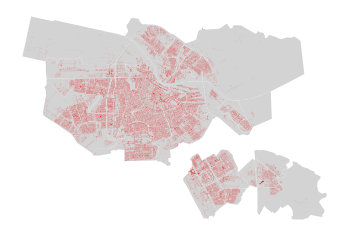

In [31]:
# Plot geodataframes together
fig, ax = plt.subplots(figsize=(6,6))

gdf_area.plot(ax=ax, color='lightgrey')
gdf_bgt_area.plot(ax=ax, color='red')

ax.axis('off')
plt.show()

#### Use spatial join to create summary

In [32]:
gdf_bgt_area_sum = gdf_bgt_area.groupby('naam').sum()

In [33]:
gdf_bgt_area_sum['area'].sort_values()

naam
Nieuwendammerdijk/Buiksloterdijk     10765.40
IJburg-Oost                          11356.40
Vondelparkbuurt                      19562.02
Noordelijke IJ-oevers-Oost           23283.50
Tuindorp Buiksloot                   28347.39
                                      ...    
Amstel III/Bullewijk                236423.01
Osdorp-Oost                         267972.79
Geuzenveld                          276102.59
Buitenveldert-West                  294010.32
Sloten/Nieuw-Sloten                 297797.82
Name: area, Length: 110, dtype: float64

Note: if you want to group and aggregate geometries, you can use dissolve (https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html)

## 4. Creating plots

#### Plot specific location, with different backgrounds

In [34]:
# Select coordinates for visualisation (for example right click on Google Maps)
my_lat = 52.361207 # Weesperplein
my_lon = 4.908029 

In [35]:
# Set size of location you want to look at (50 results in 100x100 square)
my_rad = 50

In [36]:
# Define visualisation area (by buffering around selected point)
df_loc = gpd.GeoDataFrame({'geometry': [sg.Point(my_lon, my_lat)]}, crs="epsg:4326").to_crs(CRS)
df_loc['buffer'] = df_loc['geometry'].buffer(my_rad, cap_style=3)

In [37]:
df_loc

,geometry,buffer
0,POINT (122359.695 486031.780),"POLYGON ((122409.695 486081.780, 122409.695 48..."


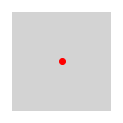

In [38]:
# Plot geodataframes together
fig, ax = plt.subplots(figsize=(2,2))

df_loc.set_geometry('buffer').plot(ax=ax, color='lightgrey')
df_loc.plot(ax=ax, color='red')

ax.axis('off')
plt.show()

In [39]:
# Use spatial join to only get polygons within buffered area
gdf_bgt_loc = gdf_bgt.sjoin(df_loc.set_geometry('buffer'), how='inner').set_geometry('geometry_left')

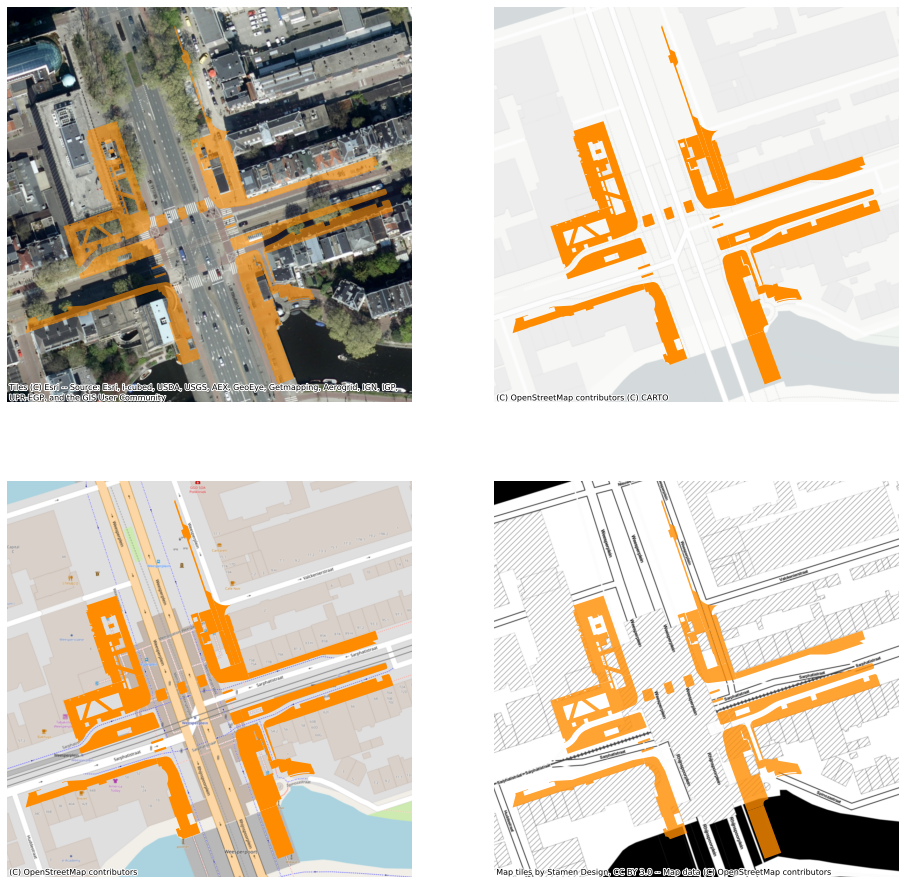

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))

gdf_bgt_loc.plot(ax=ax1, color='darkorange', alpha=0.6)
cx.add_basemap(ax=ax1, source=cx.providers.Esri.WorldImagery, crs=CRS)

gdf_bgt_loc.plot(ax=ax2, color='darkorange')
cx.add_basemap(ax=ax2, source=cx.providers.CartoDB.PositronNoLabels, crs=CRS)

gdf_bgt_loc.plot(ax=ax3, color='darkorange')
cx.add_basemap(ax=ax3, source=cx.providers.OpenStreetMap.Mapnik, crs=CRS)

gdf_bgt_loc.plot(ax=ax4, color='darkorange', alpha=0.8)
cx.add_basemap(ax=ax4, source=cx.providers.Stamen.Toner, crs=CRS)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
plt.show()

Contextily (imported here as cx) is a package to work with web-tiles for background maps. They have many different backgrounds to choose from. See https://contextily.readthedocs.io/en/latest/intro_guide.html.

### Summary plot per neighborhood

In [41]:
gdf_bgt_area_sum.head(2)

,index_left,area
naam,,
Aetsveld/Oostelijke Vechtoever,65475.0,49405.34
Amstel III/Bullewijk,150660.0,236423.01


In [42]:
# Get area geometry column back in 
gdf_bgt_area_sum = gdf_bgt_area_sum.reset_index().merge(gdf_area)

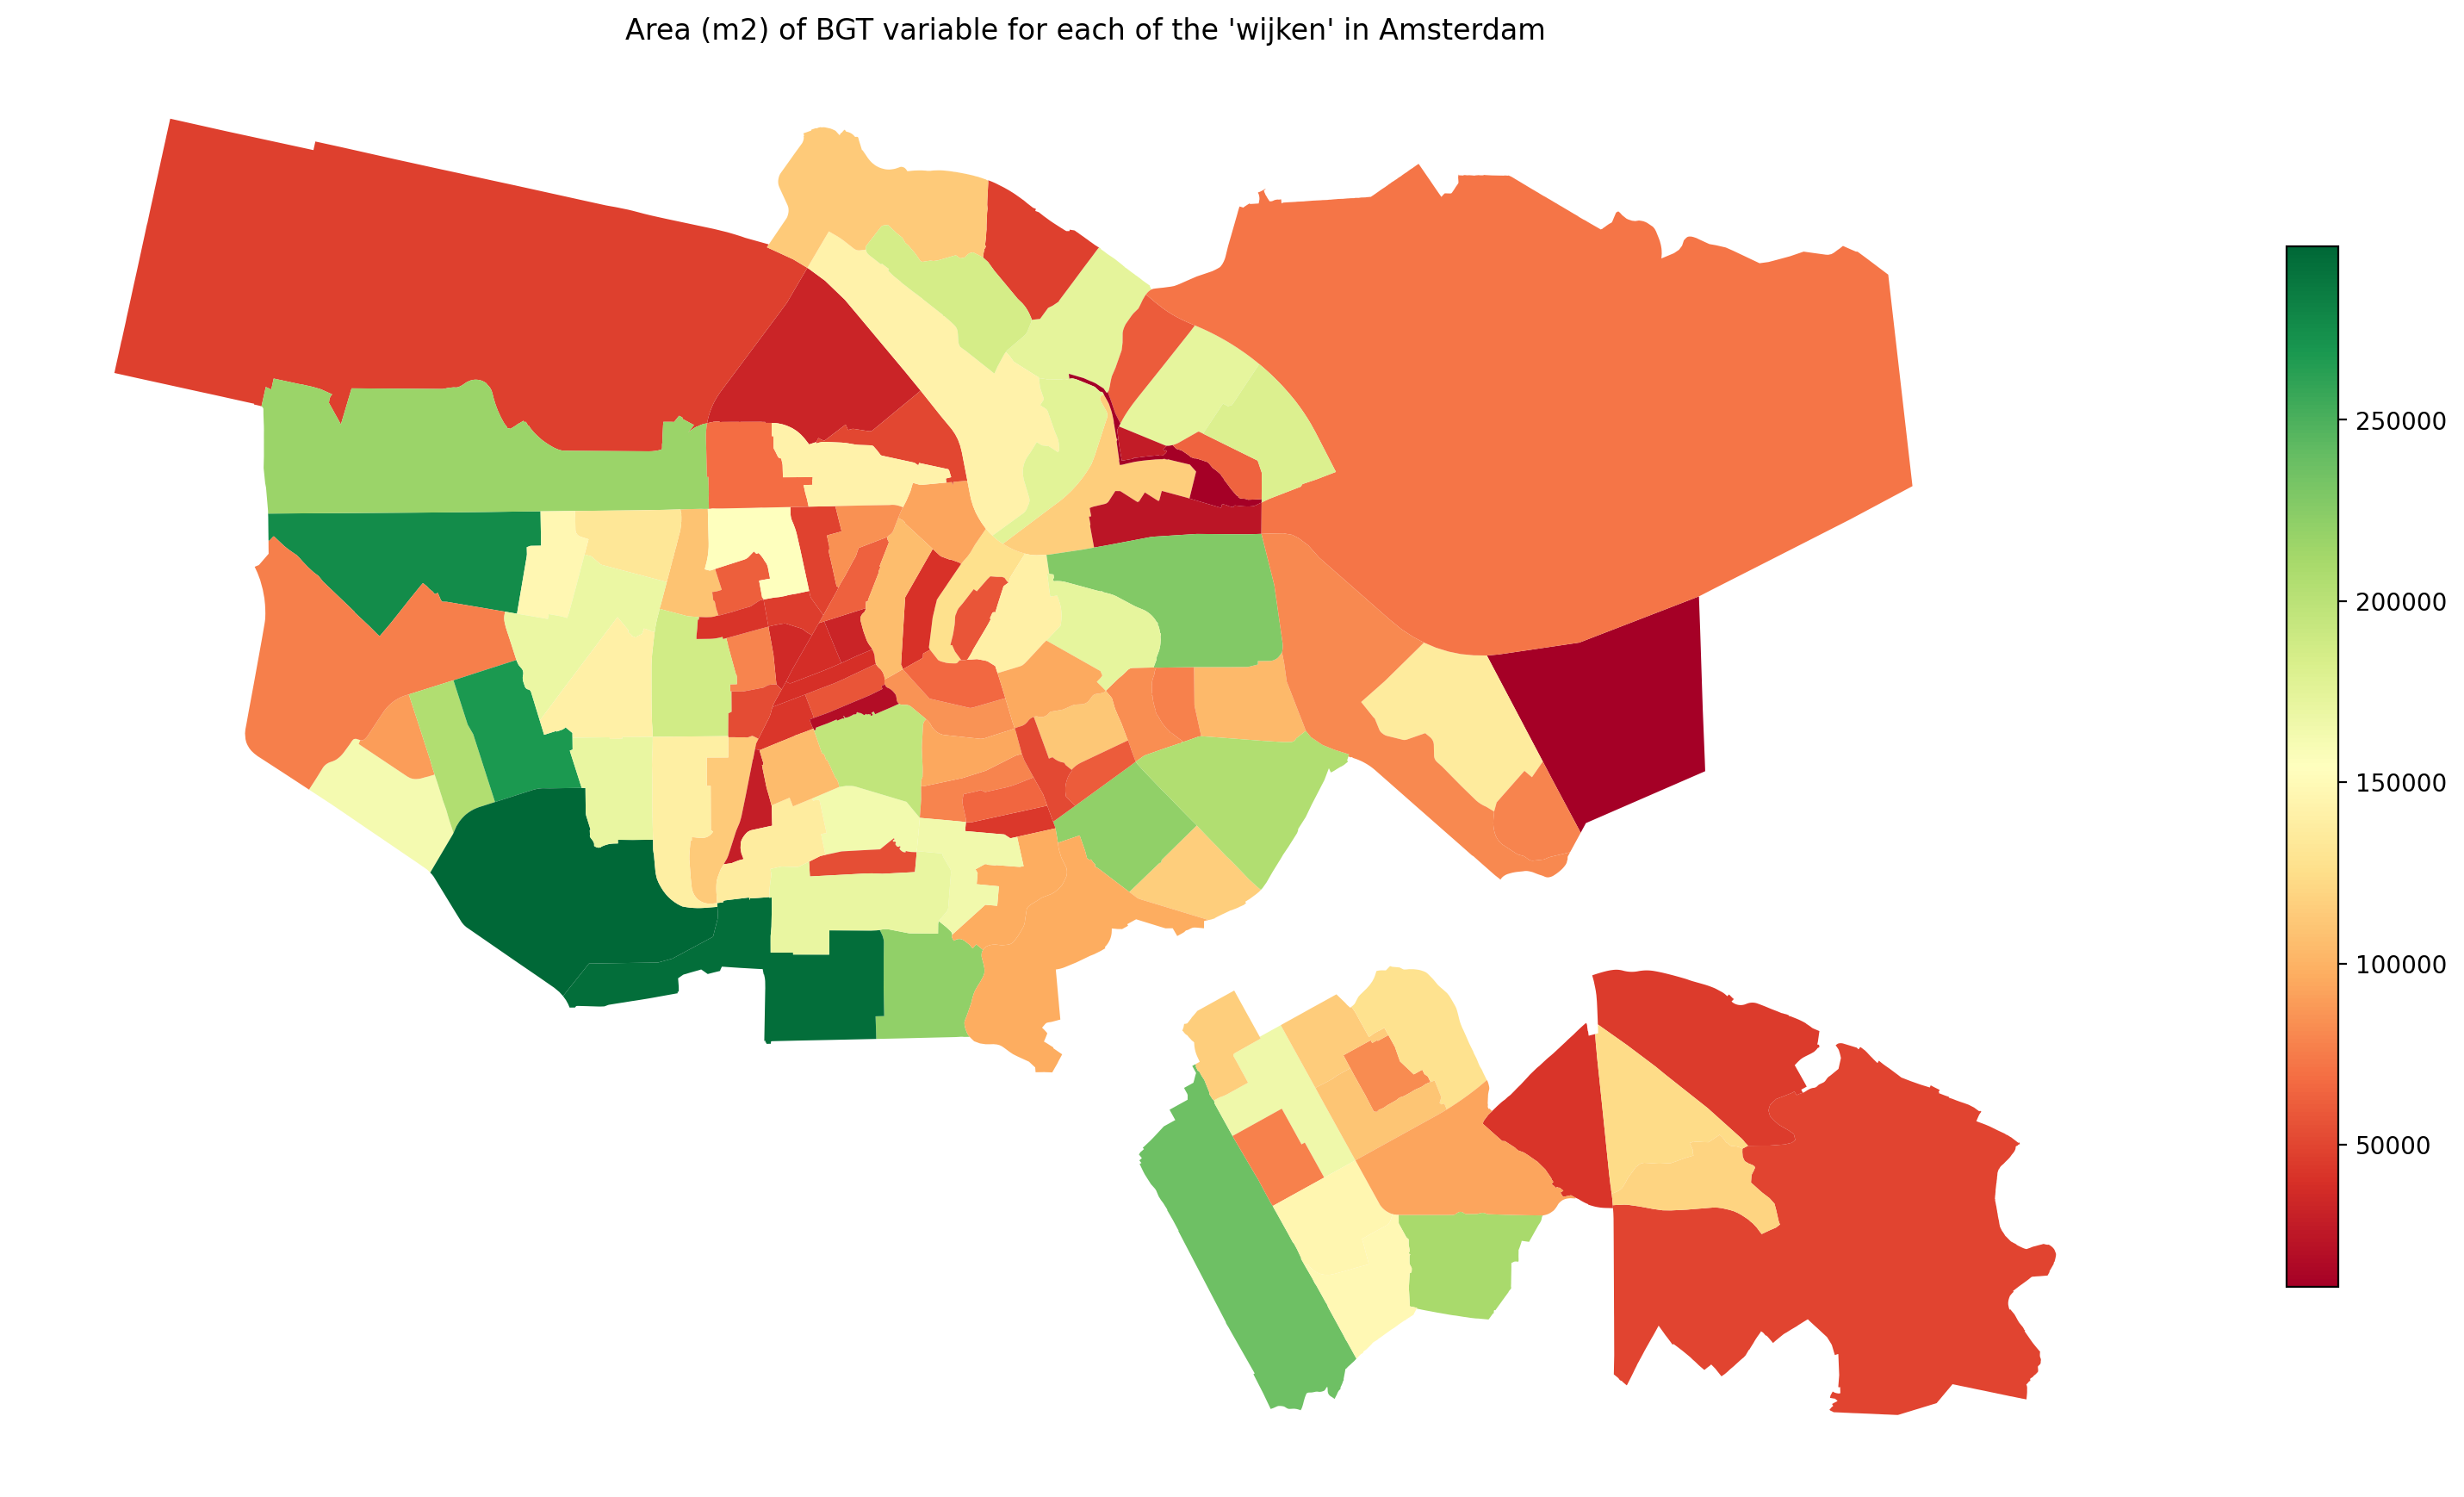

In [43]:
fig, ax = plt.subplots(figsize = (20, 20), dpi = 200, frameon = False)
gdf_bgt_area_sum.plot(ax=ax, column='area', cmap="RdYlGn", legend=True, legend_kwds={'shrink': 0.4})

plt.title ("Area (m2) of BGT variable for each of the '" + area_choice + "' in Amsterdam")

plt.axis('off')
plt.show()

## 5. Recommendations

For an introduction to geographic data science, I can recommend this course: https://darribas.org/gds_course/content/home.html, with this book: https://geographicdata.science/book/notebooks/01_geo_thinking.html.

The Shapely user manual is also very useful: https://shapely.readthedocs.io/en/latest/manual.html

It is nice to look around https://maps.amsterdam.nl/?LANG=en for maps of Amsterdam, and the corresponding data can be found here: https://maps.amsterdam.nl/open_geodata/. Or you can look at the city in 3D: https://3d.amsterdam.nl/
        
The general data portal for the city (to check what other (spatial) data is available), can be found here: https://data.amsterdam.nl/